# Phase 4 — Analysis

**Goal:** Analyze model behavior and produce visuals and dashboards for sharing insights.

**Inputs:** Phase-3 bundle + meta, Phase-2 modeling table.

**Outputs (example):**
- `reports/figs/*.png`  (explanations, slices, diagnostics)

**Assumptions:**
- Figures and dashboards read the same features used at train time.
- Local paths are set so the app can discover the newest bundle and meta.


In [15]:
# ===== 1) IMPORTS =====

# --- Standard library ---
import os
import sys
import re
import glob
import json
import warnings
import unicodedata
import textwrap
from pathlib import Path
from datetime import datetime, timezone

# --- Third-party ---
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    precision_recall_fscore_support,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve

import joblib

# --- Local ---
from models.soft_voting_ensemble import SoftVotingEnsemble

In [35]:
# ===== 2) CONFIG =====
BUNDLE_PATH = globals().get("BUNDLE_PATH") or os.environ.get("BUNDLE_PATH")
META_PATH   = globals().get("META_PATH")   or os.environ.get("META_PATH")
INPUT_PATH  = globals().get("INPUT_PATH")  or os.environ.get("INPUT_PATH")

In [18]:
# ===== 3) MORE SETUP =====

warnings.filterwarnings("ignore")

# work from repo root (folder that contains 'data/')
def find_repo_root(start: Path = Path.cwd(), must_have=("data",)):
    p = start
    while True:
        if all((p / m).exists() for m in must_have):
            return p
        if p.parent == p:
            raise FileNotFoundError(f"Could not find a repo root above {start} containing {must_have}")
        p = p.parent

REPO_ROOT = find_repo_root()
os.chdir(REPO_ROOT)
print("Repo root:", REPO_ROOT)
print("CWD set to:", Path.cwd())

# project dirs 
MODELS_DIR  = REPO_ROOT / "models"
REPORTS_DIR = REPO_ROOT / "reports"
FIG_DIR     = REPORTS_DIR / "figs"
for d in (MODELS_DIR, REPORTS_DIR, FIG_DIR):
    d.mkdir(parents=True, exist_ok=True)

DATA_DIR = REPO_ROOT / "data" / "processed"

# helper
def _latest(patterns, roots):
    """Return newest file matching any pattern in the given roots, or None."""
    if isinstance(patterns, (str, Path)): patterns = [patterns]
    if isinstance(roots, (str, Path)):    roots = [roots]
    cands = []
    for r in map(Path, roots):
        if not r.exists():
            continue
        for pat in patterns:
            cands += list(r.glob(pat))
    return str(max(cands, key=lambda p: p.stat().st_mtime)) if cands else None

# guard against NameError if these aren't defined yet
BUNDLE_PATH = BUNDLE_PATH if 'BUNDLE_PATH' in globals() else None
META_PATH   = META_PATH   if 'META_PATH'   in globals() else None
INPUT_PATH  = INPUT_PATH  if 'INPUT_PATH'  in globals() else None

# auto-discover artifacts if not set OR missing on disk
if (not BUNDLE_PATH) or (not Path(str(BUNDLE_PATH)).exists()):
    BUNDLE_PATH = _latest(
        ["phase3_bundle_*.joblib", "*bundle*.joblib"],
        [MODELS_DIR, MODELS_DIR / "phase3"]
    )

if (not META_PATH) or (not Path(str(META_PATH)).exists()):
    META_PATH = _latest(["bundle_meta_*.json", "metrics_*.json"], REPORTS_DIR)

if (not INPUT_PATH) or (not Path(str(INPUT_PATH)).exists()):
    INPUT_PATH = (
        _latest("ml_table_*.parquet", [DATA_DIR, DATA_DIR / "phase2_prototype"])
        or _latest("all_days.parquet", DATA_DIR)
        or _latest("*.parquet", DATA_DIR)
        or _latest("all_days.csv", DATA_DIR)
        or _latest("*.csv", DATA_DIR)
    )

def _yn(p): 
    return (Path(p).exists() if p else False)

print(f"  Bundle: {BUNDLE_PATH}  (exists: {_yn(BUNDLE_PATH)})")
print(f"  Meta  : {META_PATH}    (exists: {_yn(META_PATH)})")
print(f"  Input : {INPUT_PATH}   (exists: {_yn(INPUT_PATH)})")



Repo root: /Users/asmitabisht/Desktop/repo
CWD set to: /Users/asmitabisht/Desktop/repo
  Bundle: /Users/asmitabisht/Desktop/repo/models/phase3_bundle_Ensemble(LR+LGBM)_2025-09-22T03-30-14Z.joblib  (exists: True)
  Meta  : /Users/asmitabisht/Desktop/repo/reports/bundle_meta_2025-09-22T03-30-14Z.json    (exists: True)
  Input : /Users/asmitabisht/Desktop/repo/data/processed/ml_table_2025-09-22T03-12-02Z.parquet   (exists: True)


In [ ]:
# ==== 4) LOAD BUNDLE & META ====

try:
    # ensure custom estimator class is importable for unpickling
    sys.modules['__main__'].SoftVotingEnsemble = SoftVotingEnsemble
except Exception:
    print("Could not pre-register SoftVotingEnsemble")

# load artifacts
bundle = joblib.load(BUNDLE_PATH)
with open(META_PATH, "r") as f:
    meta = json.load(f)

# validate pipeline & resolve final estimator name ('model' or 'clf')
if not hasattr(bundle, "named_steps"):
    raise TypeError("Expected a sklearn Pipeline in bundle.")

steps = bundle.named_steps
if "pre" not in steps or not (("model" in steps) or ("clf" in steps)):
    raise TypeError(f"Pipeline missing expected steps. Found: {list(steps.keys())}")

final_est = steps.get("model", steps.get("clf"))
has_proba = hasattr(final_est, "predict_proba")

print({
    "pipeline_steps": list(steps.keys()),
    "final_estimator": type(final_est).__name__,
    "has_predict_proba": has_proba,
})

# pull thresholds/params from meta with safe fallbacks
THR      = float(meta.get("threshold_val_top_frac", meta.get("threshold", 0.5)))
TOP_FRAC = float(meta.get("top_frac", 0.10))
print({
    "winner": meta.get("winner") or meta.get("overall_winner"),
    "winner_space": meta.get("winner_space"),
    "thr": THR,
    "top_frac": TOP_FRAC,
})


{'pipeline_steps': ['pre', 'clf'], 'final_estimator': 'SoftVotingEnsemble', 'has_predict_proba': True}
{'winner': 'Ensemble(LR+LGBM)', 'winner_space': 'sparse', 'thr': 0.3333333333333333, 'top_frac': 0.1}


In [39]:
# ==== 5) BUILD/LOAD TEST SET & COMPUTE PROBABILITIES  ====

#  helpers 
def _latest(patterns, roots):
    if isinstance(patterns, (str, Path)): patterns = [patterns]
    if isinstance(roots, (str, Path)):    roots = [roots]
    cands = []
    for r in roots:
        for pat in patterns:
            cands += glob.glob(str(Path(r) / pat))
    cands.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return cands[0] if cands else None

def _load_df(path):
    p = Path(path)
    return pd.read_parquet(p) if p.suffix.lower()==".parquet" else pd.read_csv(p)

def _clean_text_columns(df):
    tx = ['title','description','tags_text']
    out = df.copy()
    for col in tx:
        if col not in out.columns:
            out[col] = ''
        out[col] = (out[col].astype(str)
                    .replace({'nan':'','None':''})
                    .fillna('')
                    .str.replace(r'\s+', ' ', regex=True)
                    .str.strip())
    if 'tags_text' in out.columns:
        blank = out['tags_text'].str.strip()==''
        out.loc[blank, 'tags_text'] = 'no_tags'
    return out

def _is_transformer(obj):
    # looks like a pure transformer (no predict/proba/decision)
    return hasattr(obj, "transform") and not any(
        hasattr(obj, a) for a in ("predict_proba", "predict", "decision_function")
    )

def _final_estimator(obj):
    """Return the final estimator if Pipeline, else the object itself."""
    if hasattr(obj, "named_steps") and obj.named_steps:
        return list(obj.named_steps.values())[-1]
    return obj

def _has_predict_proba(obj):
    if hasattr(obj, "predict_proba"): return True
    last = _final_estimator(obj)
    return hasattr(last, "predict_proba")

def _predict_proba_direct(obj, X):
    """Call predict_proba on obj or its final step and coerce to (n,2)."""
    target = obj
    if not hasattr(target, "predict_proba"):
        target = _final_estimator(obj)
    P = np.asarray(target.predict_proba(X))
    if P.ndim == 1:
        return np.c_[1.0 - P, P]
    if P.shape[1] == 1:
        return np.c_[1.0 - P[:, 0], P[:, 0]]
    return P 

# reuse saved eval if present
EVAL_PATH     = _latest("test_eval_*.parquet", REPORTS_DIR)
TEST_IDX_PATH = _latest("test_indices_*.npy", REPORTS_DIR)

y_test = None
p_test_final = None
X_test = None

if EVAL_PATH:
    try:
        _eval = pd.read_parquet(EVAL_PATH)
        if {"y_test","p_test_final"}.issubset(_eval.columns):
            y_test       = _eval["y_test"].to_numpy().astype(int)
            p_test_final = _eval["p_test_final"].to_numpy().astype(float)
            print("Loaded prior test eval:", EVAL_PATH, "| n =", len(y_test))
        else:
            print("Saved eval exists but missing columns; will recompute.")
    except Exception as e:
        print("Failed to load prior eval; will recompute. Reason:", e)

#  compute fresh if needed
if y_test is None or p_test_final is None:
    assert INPUT_PATH and os.path.exists(INPUT_PATH), "Need INPUT_PATH with a Phase-2 table."
    df_all = _load_df(INPUT_PATH)
    assert 'viral' in df_all.columns, "Dataset must include a 'viral' label."
    df_all = _clean_text_columns(df_all)

    y = df_all['viral'].astype(int).to_numpy()
    X = df_all.drop(columns=['viral']).copy()

    # reuse saved indices if available
    if TEST_IDX_PATH and os.path.exists(TEST_IDX_PATH):
        test_idx = np.load(TEST_IDX_PATH)
        X_test = X.iloc[test_idx].copy()
        y_test = y[test_idx]
        print("Reconstructed X_test by saved indices:", X_test.shape)
    else:
        TEST_SIZE    = globals().get("TEST_SIZE", 0.2)
        RANDOM_STATE = globals().get("RANDOM_STATE", 42)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
        )
        try:
            idx = X_test.index.to_numpy()
            Path(REPORTS_DIR).mkdir(parents=True, exist_ok=True)
            np.save(Path(REPORTS_DIR)/f"test_indices_{datetime.now(timezone.utc).strftime('%Y-%m-%dT%H-%M-%SZ')}.npy", idx)
        except Exception:
            pass

    # score
    last = _final_estimator(bundle)
    if _is_transformer(last):
        raise RuntimeError(
            "Loaded artifact ends with a transformer (no classifier). "
        )
    if not _has_predict_proba(bundle):
        # very rare
        if hasattr(last, "decision_function"):
            d = np.asarray(last.decision_function(X_test))
            if d.ndim == 1:
                p1 = 1.0 / (1.0 + np.exp(-d))
                P = np.c_[1.0 - p1, p1]
            else:
                ex = np.exp(d - d.max(axis=1, keepdims=True))
                P = ex / ex.sum(axis=1, keepdims=True)
        else:
            raise RuntimeError(
                "Final estimator has neither predict_proba nor decision_function. "
            )
    else:
        P = _predict_proba_direct(bundle, X_test)

    p_test_final = P[:, 1]

    # persist for reuse
    stamp = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")
    out_eval = pd.DataFrame({"y_test": y_test, "p_test_final": p_test_final})
    out_path = Path(REPORTS_DIR) / f"test_eval_{stamp}.parquet"
    out_eval.to_parquet(out_path, index=False)
    print("Saved test eval ->", out_path.as_posix())


Loaded prior test eval: /Users/asmitabisht/Desktop/repo/reports/test_eval_2025-09-22T03-58-30Z.parquet | n = 1048


In [40]:
# ===== 6) PLOT STYLE & FIGURE SAVER HELPER =====
mpl.rcParams.update({
    "figure.figsize": (5.0, 3.6),
    "figure.dpi": 180,
    "axes.titlesize": 11, "axes.labelsize": 9,
    "xtick.labelsize": 8, "ytick.labelsize": 8,
    "legend.fontsize": 8, "lines.linewidth": 1.6,
})
STAMP = datetime.utcnow().strftime("%Y%m%d_%H%M%S")

def save_fig_show(name):
    fp = FIG_DIR / f"{name}_{STAMP}.png"
    plt.savefig(fp, dpi=180, bbox_inches="tight", pad_inches=0.02)
    print("Saved:", fp.as_posix())
    plt.show()
    plt.close()


Saved: /Users/asmitabisht/Desktop/repo/reports/figs/pr_curve_test_20250922_040850.png


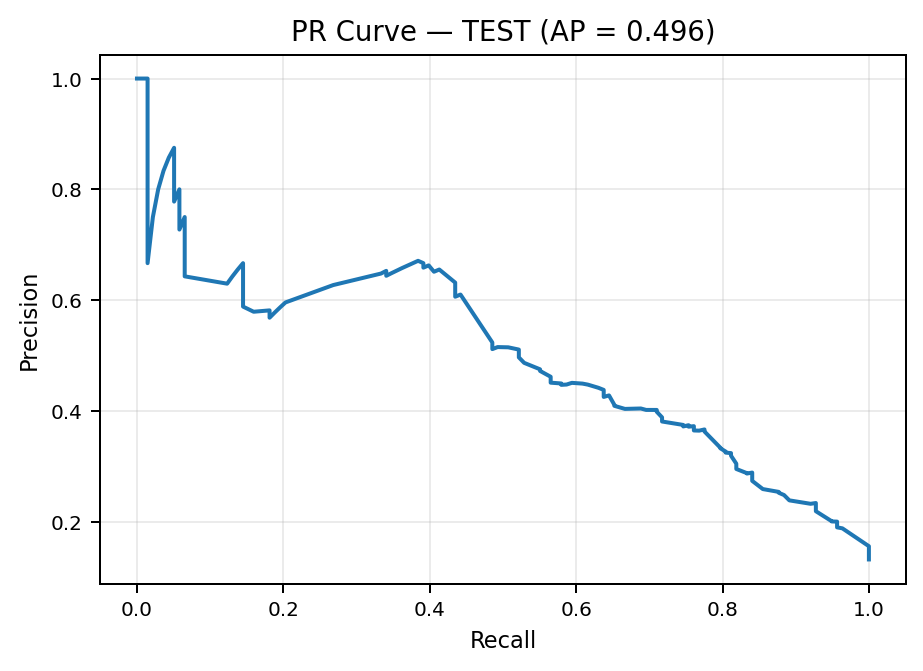

Saved: /Users/asmitabisht/Desktop/repo/reports/figs/roc_curve_test_20250922_040850.png


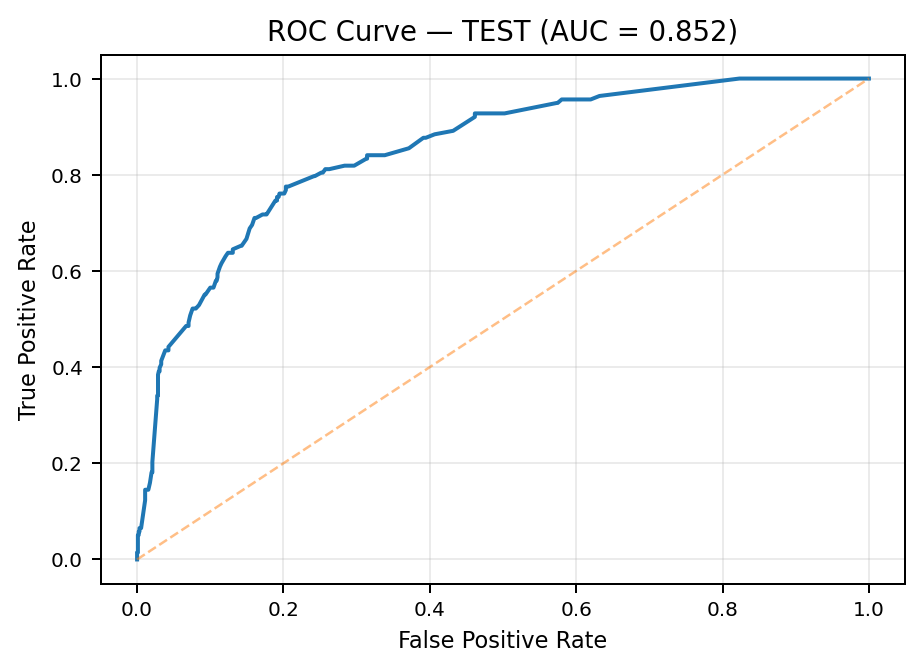

Saved: /Users/asmitabisht/Desktop/repo/reports/figs/reliability_curve_test_20250922_040850.png


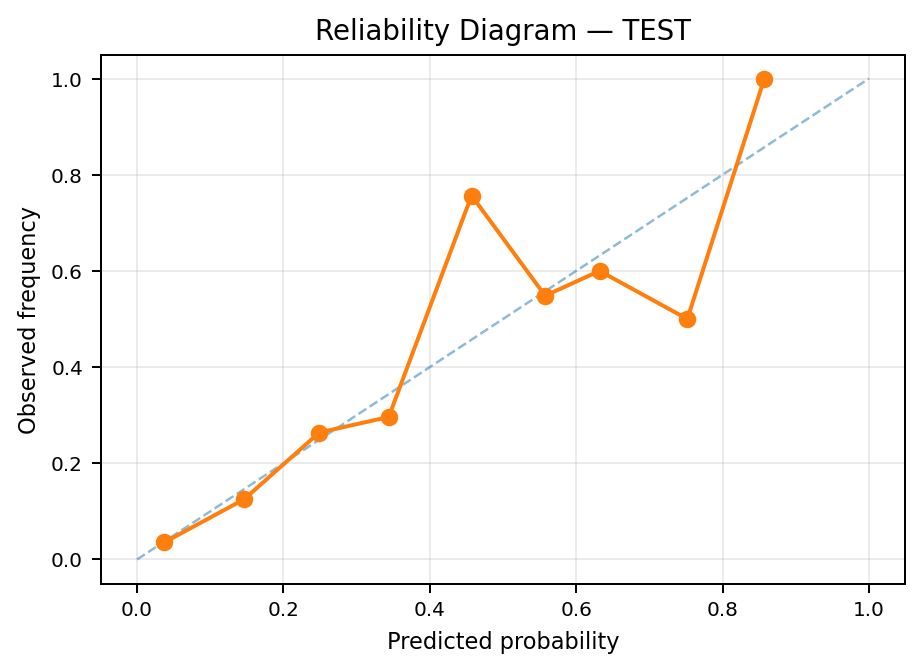

Saved: /Users/asmitabisht/Desktop/repo/reports/figs/score_hist_test_20250922_040850.png


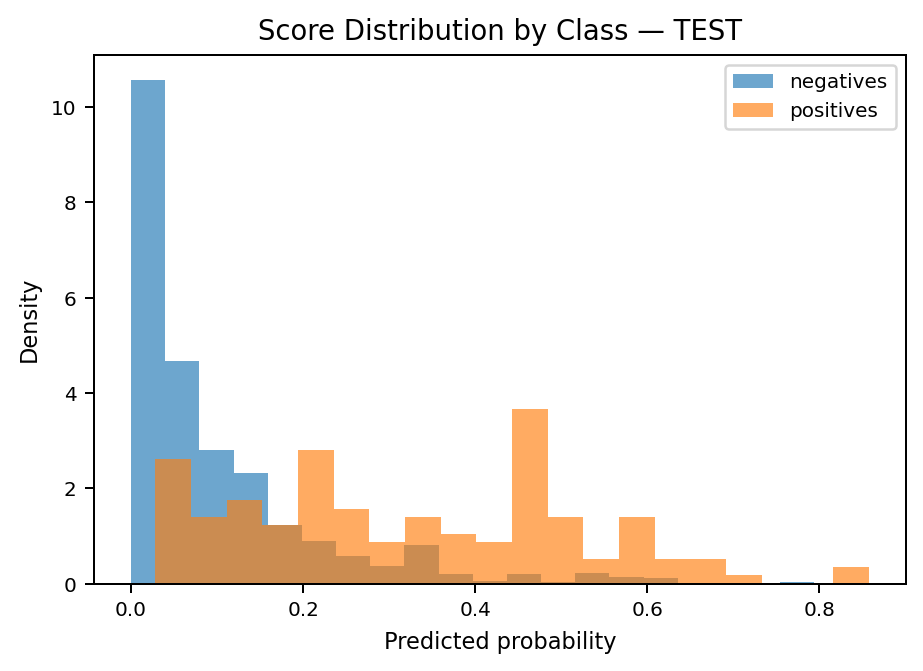

In [41]:
# ===== 7) MODEL PERFORMANCE ON TEST: PR/ROC/Calibration/Histogra =====

y = np.asarray(y_test).astype(int)
p = np.asarray(p_test_final).astype(float)

# PR
prec, rec, _ = precision_recall_curve(y, p)
ap = average_precision_score(y, p)
plt.figure()
plt.plot(rec, prec)
plt.title(f"PR Curve — TEST (AP = {ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.grid(alpha=0.25); plt.tight_layout(pad=0.25)
save_fig_show("pr_curve_test")

# ROC
fpr, tpr, _ = roc_curve(y, p)
auc = roc_auc_score(y, p)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--',lw=1,alpha=0.5)
plt.title(f"ROC Curve — TEST (AUC = {auc:.3f})")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(alpha=0.25); plt.tight_layout(pad=0.25)
save_fig_show("roc_curve_test")

# reliability
prob_true, prob_pred = calibration_curve(y, p, n_bins=10, strategy="uniform")
plt.figure()
plt.plot([0,1],[0,1],'--',lw=1,alpha=0.5)
plt.plot(prob_pred, prob_true, marker='o')
plt.title("Reliability Diagram — TEST")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.grid(alpha=0.25); plt.tight_layout(pad=0.25)
save_fig_show("reliability_curve_test")

# score histogram
plt.figure()
plt.hist(p[y==0], bins=20, density=True, alpha=0.65, label="negatives")
plt.hist(p[y==1], bins=20, density=True, alpha=0.65, label="positives")
plt.title("Score Distribution by Class — TEST")
plt.xlabel("Predicted probability"); plt.ylabel("Density")
plt.legend(); plt.tight_layout(pad=0.25)
save_fig_show("score_hist_test")


In [42]:
# ===== 8) SHAP (content-only tabular clone) =====

#  pick a small, representative subset for speed (≤200 rows) 
if 'X_test' in globals() and 'y_test' in globals() and X_test is not None:
    X_small = X_test.copy()
    y_small = np.asarray(y_test).astype(int)
else:
    # fall back to full dataset if present
    p = Path(INPUT_PATH)
    df_all = pd.read_parquet(p) if p.suffix.lower()==".parquet" else pd.read_csv(p)
    y_all = df_all['viral'].astype(int).to_numpy()
    X_all = df_all.drop(columns=['viral']).copy()
    # take a stratified sample
    take = min(200, len(X_all))
    idx = np.linspace(0, len(X_all)-1, num=take, dtype=int)
    X_small = X_all.iloc[idx].copy()
    y_small = y_all[idx]

# define content-only columns 
if 'num_cols' in globals():
    num_cols_c = [c for c in num_cols if c in X_small.columns and not c.startswith('channel_')]
else:
    num_cols_c = list(X_small.select_dtypes(include=[np.number]).columns)
    num_cols_c = [c for c in num_cols_c if not c.startswith('channel_')]

if 'cat_cols' in globals():
    cat_cols_c = [c for c in cat_cols if c in X_small.columns and not c.startswith('channel_')]
else:
    # common single categorical in your setup
    cat_cols_c = [c for c in X_small.select_dtypes(exclude=[np.number]).columns if c in ['categoryId']]

# safety: scale down to only the columns we’ll actually feed
use_cols = sorted(set(num_cols_c + cat_cols_c))
X_small = X_small[use_cols].copy()

# replace infinities and keep NaNs for imputers
for c in X_small.columns:
    if np.issubdtype(X_small[c].dtype, np.number):
        X_small[c] = np.where(np.isfinite(X_small[c]), X_small[c], np.nan)

#  build preprocessing with imputers
num_pipe_c = SkPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler(with_mean=False)),
])

cat_pipe_c = SkPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore')),
])

pre_tab_c = ColumnTransformer(
    transformers=[
        ('num', num_pipe_c, num_cols_c),
        ('cat', cat_pipe_c, cat_cols_c),
    ],
    remainder='drop',
    sparse_threshold=1.0,
)

#  simple, interpretable classifier for tabular SHAP 
tabular_clf = LogisticRegression(max_iter=500)

tabular_pipe = SkPipeline([
    ('pre',   pre_tab_c),
    ('model', tabular_clf),
])

# fit the small clone
tabular_pipe.fit(X_small, y_small)

#  build SHAP objects on the transformed design matrix 
pre_c   = tabular_pipe.named_steps['pre']
model_c = tabular_pipe.named_steps['model']

X_trans = pre_c.transform(X_small)
if hasattr(X_trans, "toarray"):
    X_trans_dense = X_trans.toarray()
else:
    X_trans_dense = X_trans

try:
    feat_names_c = pre_c.get_feature_names_out()
except Exception:
    # fallback if sklearn version/transformer mix doesn’t support it
    feat_names_c = [f"f{i}" for i in range(X_trans_dense.shape[1])]

explainer_c = shap.LinearExplainer(model_c, X_trans_dense, feature_perturbation="interventional")
vals_c      = explainer_c.shap_values(X_trans_dense)     # shape: (n_samples, n_features)
base_c      = explainer_c.expected_value

sh_c = shap.Explanation(
    values=vals_c,
    base_values=np.repeat(base_c, vals_c.shape[0]),
    data=X_trans_dense,
    feature_names=feat_names_c,
)

print("SHAP (content-only) prepared:",
      "values shape:", sh_c.values.shape,
      "| features:", len(feat_names_c),
      "| first 5 names:", feat_names_c[:5])


SHAP (content-only) prepared: values shape: (200, 24) | features: 24 | first 5 names: ['num__categoryId' 'num__duration_log1p' 'num__tags_count'
 'num__title_len_words' 'num__title_len_chars']


Filtered out (examples): ['likes_72h', 'comments_72h', 'engagement_percentile']
Saved: reports/figs/shap_global_full_20250922_041145.png


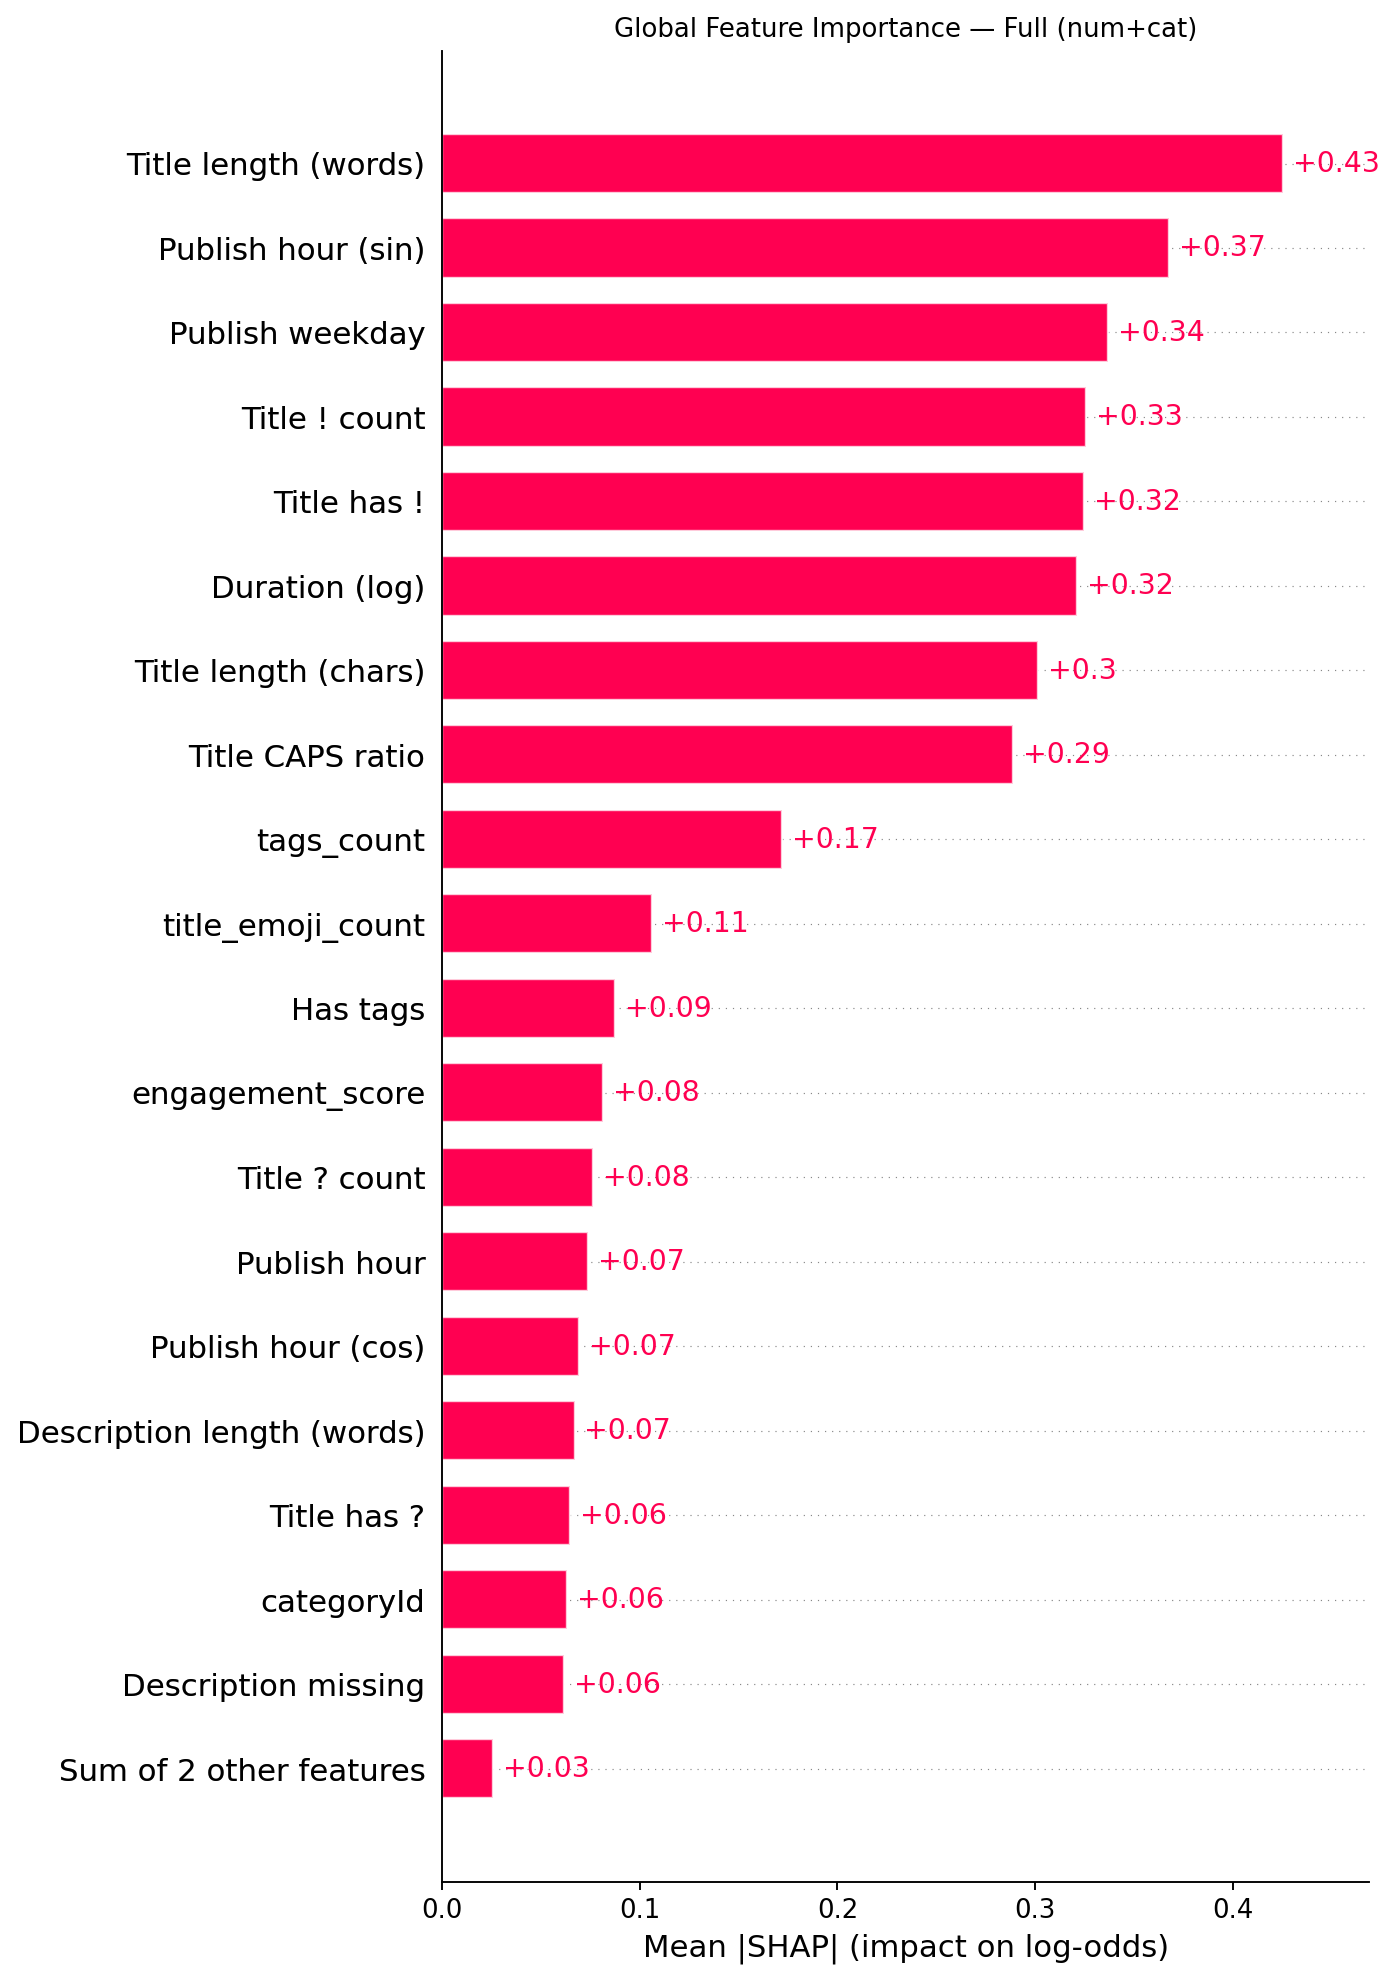

Saved: reports/figs/shap_beeswarm_full_20250922_041145.png


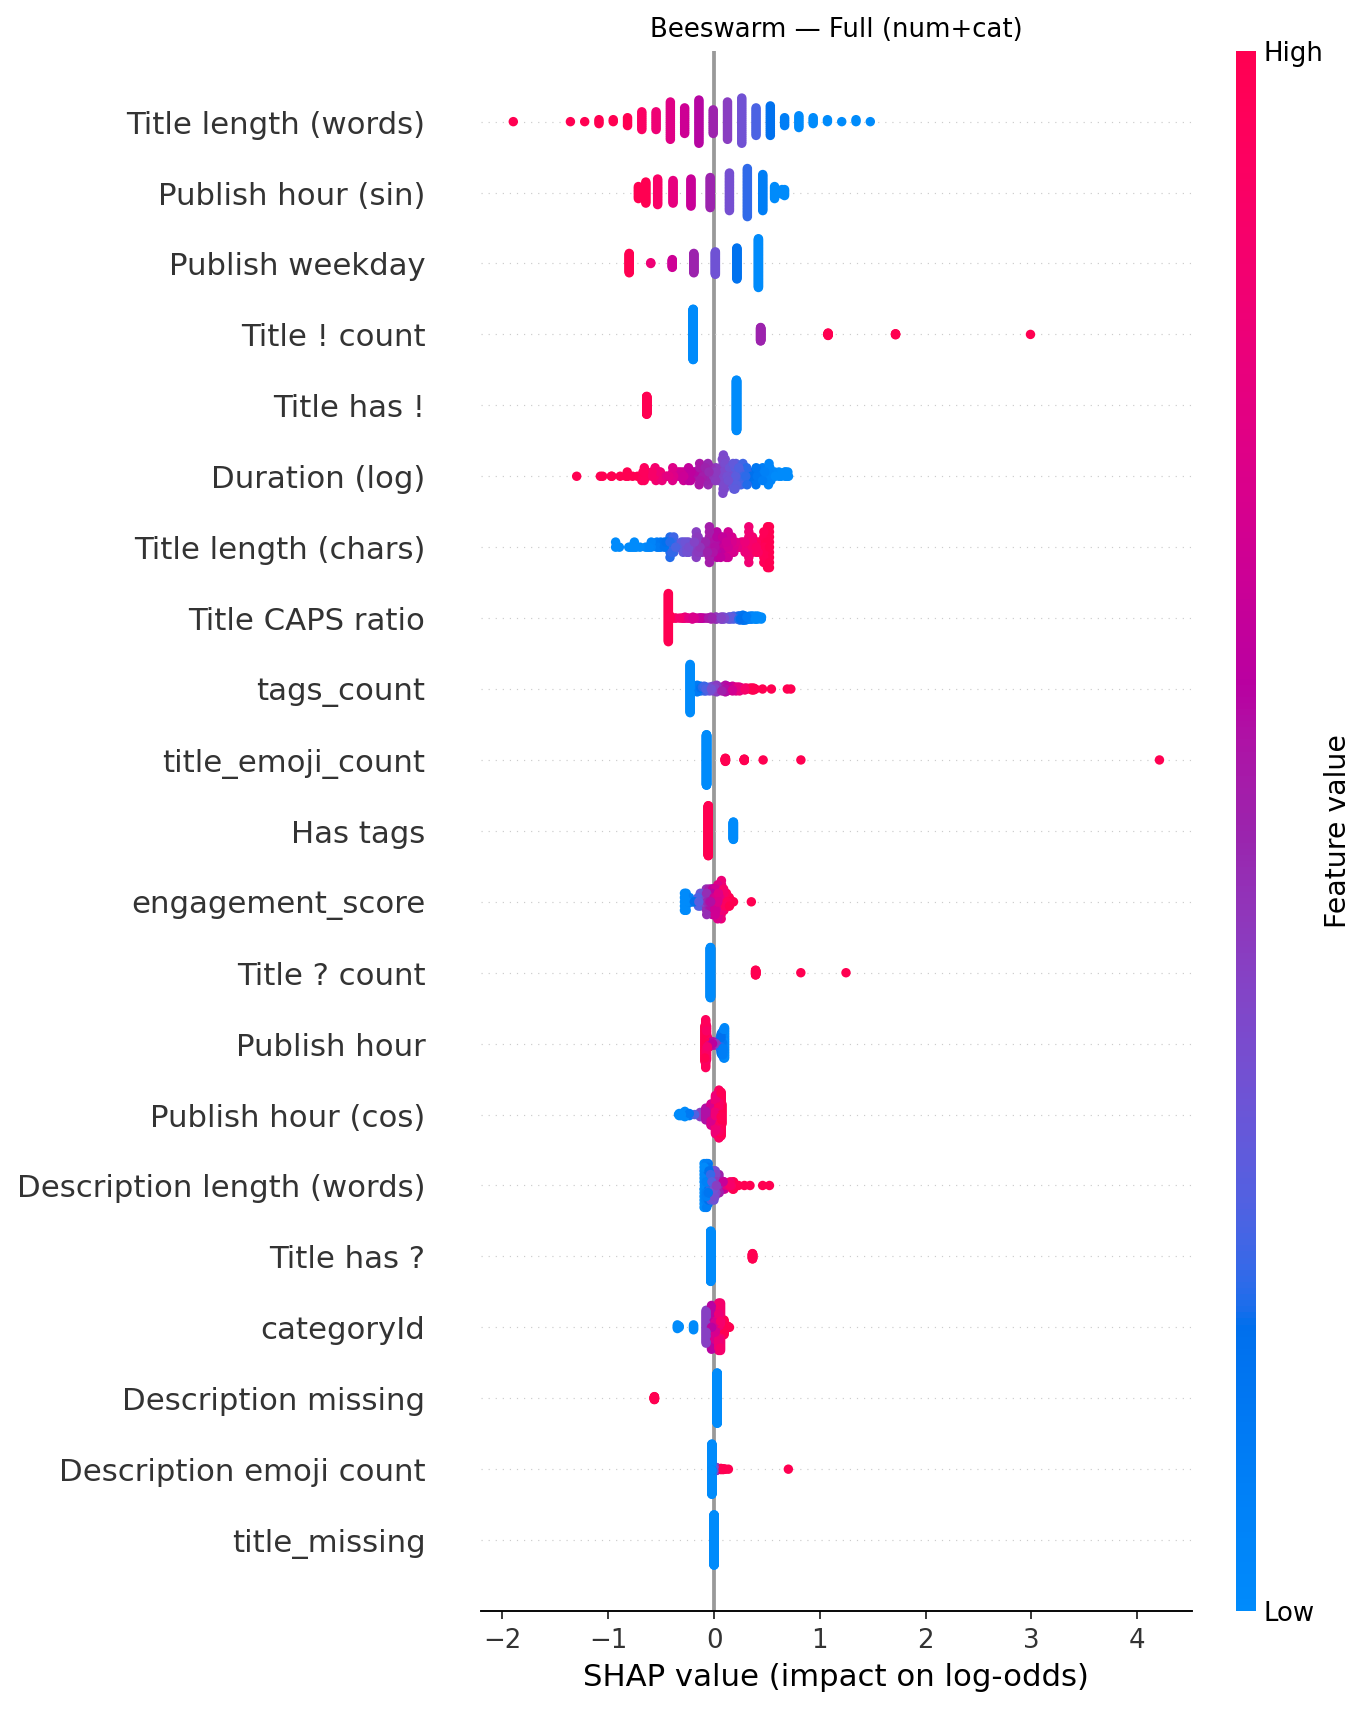

Saved: reports/figs/shap_waterfall_full_1_compact_20250922_041145.png


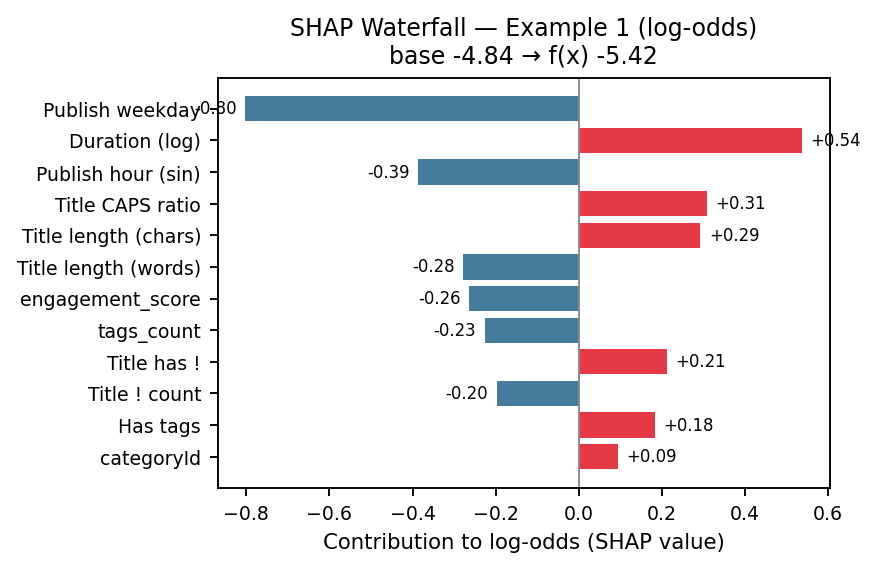

Saved: reports/figs/shap_waterfall_full_2_compact_20250922_041145.png


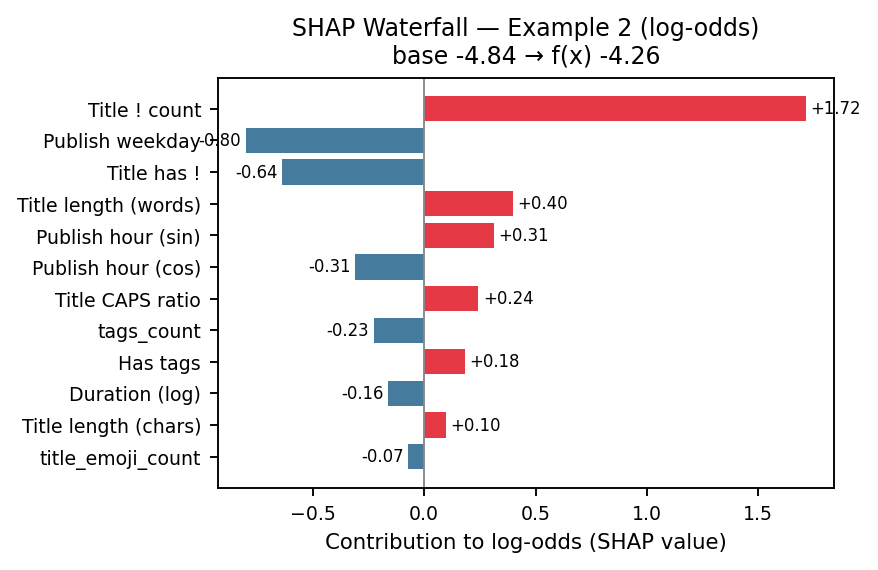

Saved: reports/figs/shap_waterfall_full_3_compact_20250922_041145.png


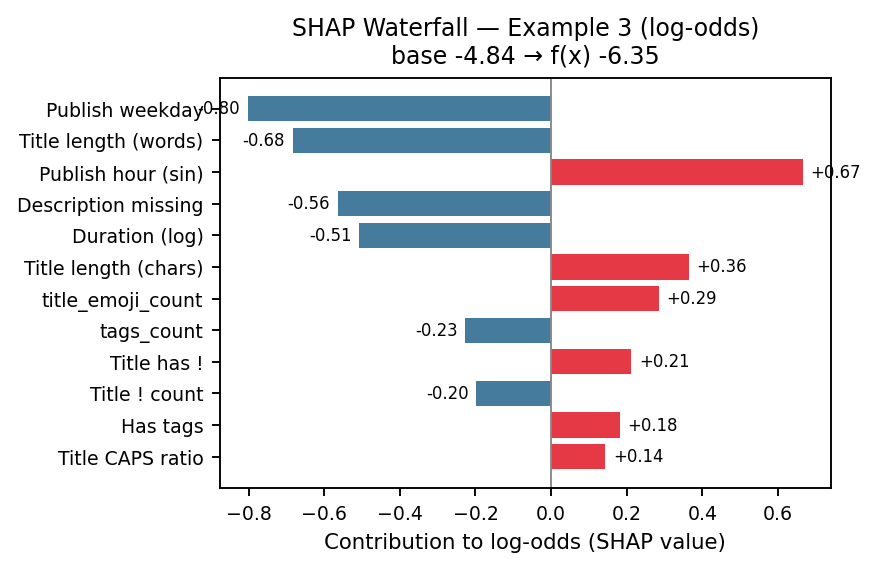

In [43]:
# ===== 9) SHAP Graph Plots =====

#  pick whichever SHAP explanation exists
if "sh" in globals() and isinstance(sh, shap.Explanation):
    base_sh = sh
elif "sh_c" in globals() and isinstance(sh_c, shap.Explanation):
    base_sh = sh_c
else:
    raise RuntimeError("No SHAP Explanation found. Run the SHAP computation cell first.")

# filter: remove 72h likes/views/comments & engagement percentile/rate/pct 
def _norm(n: str) -> str:
    return re.sub(r'^(?:pre__|num__|cat__|remainder__|model__|pipeline__)+', '', n).lower()

def _is_post_upload(n: str) -> bool:
    n = _norm(n)
    if any(k in n for k in ("engagement_percentile", "engagement_rate", "engagement_pct")):
        return True
    if "72" in n and any(k in n for k in ("view", "like", "comment", "reaction")):
        return True
    if "post_upload" in n or "after_upload" in n:
        return True
    return False

def _slice_exp(exp: shap.Explanation, keep_idx):
    keep_idx = np.asarray(keep_idx, int)
    vals = exp.values[:, keep_idx] if exp.values.ndim == 2 else exp.values[keep_idx]
    data = exp.data.toarray() if hasattr(exp.data, "toarray") else np.asarray(exp.data)
    data = data[:, keep_idx] if data.ndim == 2 else data[keep_idx]
    names = [exp.feature_names[i] for i in keep_idx]
    return shap.Explanation(values=vals, base_values=exp.base_values, data=data, feature_names=names)

_keep = [i for i, n in enumerate(base_sh.feature_names) if not _is_post_upload(n)]
if not _keep:
    raise ValueError("Filter removed all features")
if len(_keep) < len(base_sh.feature_names):
    removed = [base_sh.feature_names[i] for i in range(len(base_sh.feature_names)) if i not in _keep]
    print("Filtered out (examples):", [_norm(n) for n in removed[:10]])

base_sh = _slice_exp(base_sh, _keep)

#  pretty labels 
def short_label(name: str, max_len: int = 28) -> str:
    n = name.replace("num__", "").replace("cat__", "")
    n = n.replace("channel_viewCount_log1p", "Channel views (log)")
    n = n.replace("channel_videoCount_log1p", "Channel uploads (log)")
    n = n.replace("channel_subscriberCount_log1p", "Channel subs (log)")
    n = n.replace("title_len_words", "Title length (words)")
    n = n.replace("title_len_chars", "Title length (chars)")
    n = n.replace("title_num_exclaim", "Title ! count")
    n = n.replace("title_has_exclaim", "Title has !")
    n = n.replace("title_has_question", "Title has ?")
    n = n.replace("title_num_question", "Title ? count")
    n = n.replace("title_caps_ratio", "Title CAPS ratio")
    n = n.replace("desc_len_words", "Description length (words)")
    n = n.replace("desc_emoji_count", "Description emoji count")
    n = n.replace("pub_hour_cos", "Publish hour (cos)")
    n = n.replace("pub_hour_sin", "Publish hour (sin)")
    n = n.replace("pub_hour", "Publish hour")
    n = n.replace("pub_dow", "Publish weekday")
    n = n.replace("description_missing", "Description missing")
    n = n.replace("has_tags", "Has tags")
    n = n.replace("duration_log1p", "Duration (log)")
    m = re.match(r"categoryId[_=](\d+)", n)
    if m:
        YT_CATS = {1:"Film & Animation",2:"Autos & Vehicles",10:"Music",15:"Pets & Animals",17:"Sports",
                   19:"Travel & Events",20:"Gaming",22:"People & Blogs",23:"Comedy",24:"Entertainment",
                   25:"News & Politics",26:"Howto & Style",27:"Education",28:"Science & Tech",29:"Nonprofits",
                   30:"Movies",43:"Shows"}
        n = f"Category: {YT_CATS.get(int(m.group(1)), m.group(1))}"
    return textwrap.shorten(n, width=max_len, placeholder="…")

def prettify_explanation(sh_exp: shap.Explanation, max_len: int = 28) -> shap.Explanation:
    pretty_names = [short_label(n, max_len=max_len) for n in sh_exp.feature_names]
    return shap.Explanation(values=sh_exp.values, base_values=sh_exp.base_values,
                            data=sh_exp.data, feature_names=pretty_names)

#  plot (same as before) 
mpl.rcParams.update({"figure.figsize": (5.4, 3.6), "figure.dpi": 170, "font.size": 8})
FIG_DIR = Path("reports/figs"); FIG_DIR.mkdir(parents=True, exist_ok=True)
STAMP = datetime.utcnow().strftime("%Y%m%d_%H%M%S")

def save_fig_show(name):
    fp = FIG_DIR / f"{name}_{STAMP}.png"
    plt.savefig(fp, dpi=170, bbox_inches="tight", pad_inches=0.02)
    print("Saved:", fp.as_posix()); plt.show(); plt.close()

sh_pretty = prettify_explanation(base_sh, max_len=28)

shap.plots.bar(sh_pretty, max_display=20, show=False)
plt.title("Global Feature Importance — Full (num+cat)")
plt.xlabel("Mean |SHAP| (impact on log-odds)")
plt.tight_layout(pad=0.2); save_fig_show("shap_global_full")

shap.plots.beeswarm(sh_pretty, max_display=25, show=False)
plt.title("Beeswarm — Full (num+cat)")
plt.xlabel("SHAP value (impact on log-odds)")
plt.tight_layout(pad=0.2); save_fig_show("shap_beeswarm_full")

def plot_waterfall_compact(sh_exp, i, top_k=12, width=5.0, height=3.2, name=None):
    vals  = np.array(sh_exp.values[i]).ravel()
    names = np.array(sh_exp.feature_names)
    base  = float(np.atleast_1d(sh_exp.base_values)[i if np.ndim(sh_exp.base_values) else 0])
    idx    = np.argsort(np.abs(vals))[-top_k:][::-1]
    s_vals, s_names = vals[idx], names[idx]
    colors = np.where(s_vals >= 0, "#e63946", "#457b9d")
    fig, ax = plt.subplots(figsize=(width, height), dpi=170)
    y = np.arange(len(s_vals))[::-1]
    ax.barh(y, s_vals, color=colors, edgecolor="none"); ax.axvline(0, color="#888", lw=0.8)
    for yy, v in zip(y, s_vals):
        if v != 0:
            ax.text(v + (0.02*np.sign(v)), yy, f"{v:+.2f}",
                    va="center", ha="left" if v > 0 else "right", fontsize=7)
    ax.set_yticks(y); ax.set_yticklabels(s_names, fontsize=8)
    fx = base + float(np.sum(vals))
    ax.set_title(f"SHAP Waterfall — Example {i+1} (log-odds)\nbase {base:+.2f} → f(x) {fx:+.2f}", fontsize=10)
    ax.set_xlabel("Contribution to log-odds (SHAP value)")
    plt.tight_layout(pad=0.2); save_fig_show(name or f"shap_waterfall_compact_{i+1}")

for i in range(min(3, len(sh_pretty))):
    plot_waterfall_compact(sh_pretty, i, top_k=12, width=5.0, height=3.2,
                           name=f"shap_waterfall_full_{i+1}_compact")



Top + terms (push toward viral):
term                             weight   docs
raw                             +1.5283     19
nfl                             +1.4007     22
gta                             +1.0798     43
official                        +1.0585     26
pro                             +1.0498     24
highlights                      +0.9193     58
trump                           +0.8984    120
man                             +0.8896     32
worst                           +0.8508     19
day                             +0.8500     53
today                           +0.8325     19
war                             +0.8226     25
moraes                          +0.8152     25
maduro                          +0.7949     31
charlie                         +0.7175     43
admin                           +0.7058     45
brainrots                       +0.6804     29
real                            +0.6785     30
match                           +0.6748     20
girl                      

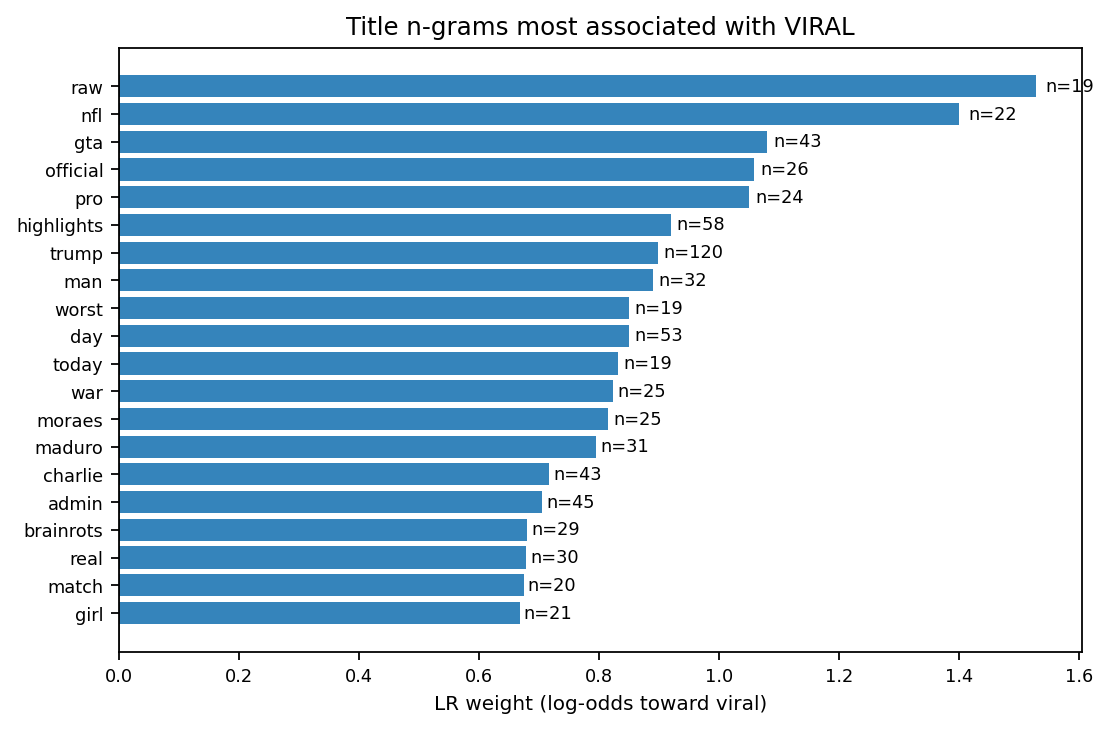

Saved: reports/figs/title_ngrams_neg_20250922_041445.png


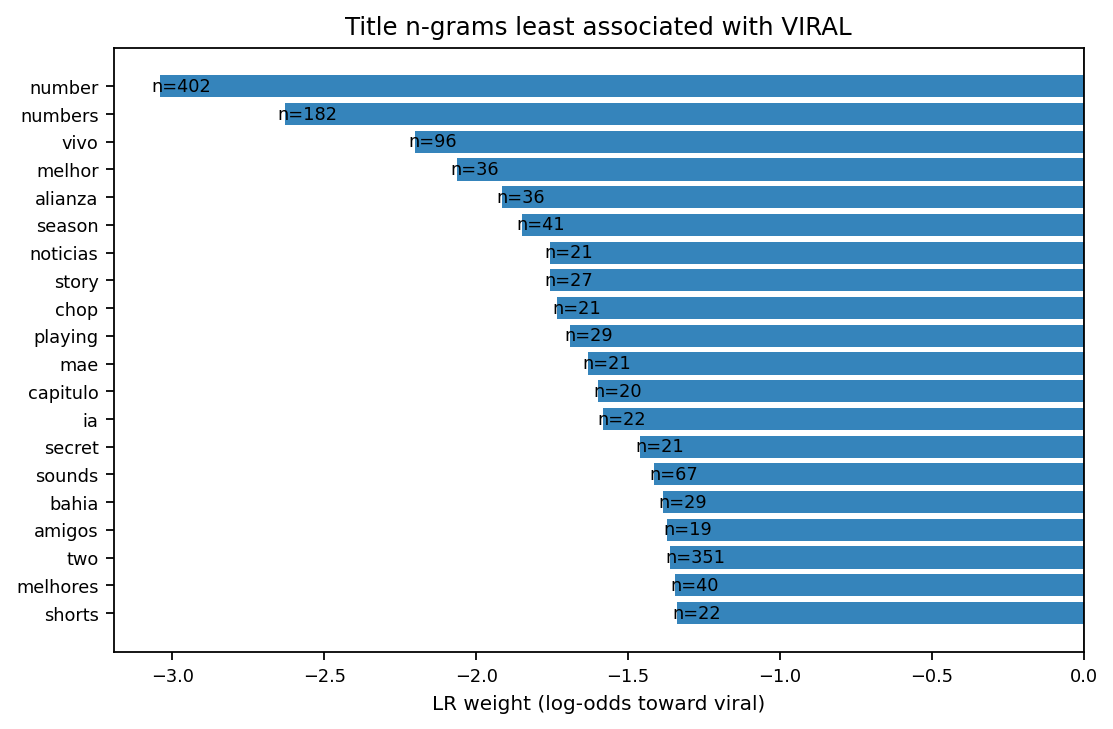

In [44]:
# =====  10) TITLE N-GRAM ANALYSIS  =====

FIG_DIR = Path("reports/figs"); FIG_DIR.mkdir(parents=True, exist_ok=True)
STAMP = datetime.utcnow().strftime("%Y%m%d_%H%M%S")

# load phase-2 table
p = Path(INPUT_PATH)
df_all = pd.read_parquet(p) if p.suffix.lower()==".parquet" else pd.read_csv(p)
titles = df_all['title'].fillna('').astype(str)

# light normalizer: lower, strip accents, collapse spaces
def normalize(text: str) -> str:
    t = text.lower()
    t = unicodedata.normalize("NFKD", t)
    t = "".join(ch for ch in t if not unicodedata.combining(ch))
    t = re.sub(r"\s+", " ", t).strip()
    return t

titles = titles.map(normalize)

# multi-lingual stopwords (small, extendable), added spanish and portugese since it was prevalent even when searching amongst US videos
STOP_EN = {
    # articles & basic
    "a","an","the",

    # conjunctions
    "and","or","but","if","while","though","because","so","than","then","once",

    # prepositions
    "of","to","in","on","for","with","by","from","at","as","about","into",
    "over","after","before","under","above","between","without","through",
    "during","within","along","across","towards","against","among",

    # pronouns
    "i","me","my","myself","we","our","ours","ourselves",
    "you","your","yours","yourself","yourselves",
    "he","him","his","himself","she","her","hers","herself",
    "it","its","itself","they","them","their","theirs","themselves",
    "this","that","these","those","us", 

    # verbs (common auxiliary & modals)
    "is","am","are","was","were","be","been","being",
    "have","has","had","having",
    "do","does","did","doing",
    "can","could","shall","should","will","would","may","might","must", "go",

    # negations & misc
    "not","no","nor","don","doesn","didn","hadn","hasn","haven",
    "isn","wasn","weren","won","wouldn","shouldn","couldn","mightn","mustn",

    # adverbs & fillers
    "very","just","only","too","also","more","most","such","much","many",
    "how","what","which","who","whom","whose","why","when","where",

    # extra conversational fillers
    "there","here","out","up","down","off","again","once","ever","always",
    "any","all","each","either","every","few","some","both","other","another",
}

STOP_PT = { # portugese
    "de","do","da","dos","das","o","a","os","as","e","ou","um","uma","no","na","nos","nas",
    "para","com","por","em","se","que","mais","menos", "minha",
}
STOP_ES = { #spanish
    "de","del","la","el","los","las","y","o","un","una","en","con","por","para","que","mas","menos"
}
MONTHS = {"january","february","march","april","may","june","july","august","september",
          "october","november","december","enero","febrero","marzo","abril","mayo","junio",
          "julio","agosto","septiembre","octubre","noviembre","diciembre",
          "janeiro","fevereiro","marco","abril","maio","junho","julho","agosto","setembro",
          "outubro","novembro","dezembro"}

CUSTOM_STOPS = STOP_EN | STOP_PT | STOP_ES | MONTHS | {"ao","sa","com","com o","sem","tudo","todos","todas", "sua"}

# tokenizer: split on non-letters, drop tokens without letters, drop stopwords & 1-char tokens
TOKEN_RE = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?", re.IGNORECASE)
def tokenize(text: str):
    toks = TOKEN_RE.findall(text)
    out = []
    for t in toks:
        t = t.strip("'")
        # keep tokens that have at least one letter and are not numeric-only
        if not any(c.isalpha() for c in t):
            continue
        if len(t) < 2:
            continue
        if t in CUSTOM_STOPS:
            continue
        out.append(t)
    return out

# vctorizer: uni+bi, min_df relative (and >=5), max_df to drop super-common tokens
N = len(titles)
min_df = max(5, int(0.003 * N))          # ~0.3% or at least 5 docs
vec = TfidfVectorizer(
    analyzer=tokenize,    
    ngram_range=(1, 2),
    min_df=min_df,
    max_df=0.6,           # drop terms in >60% of docs
    sublinear_tf=True,
    norm='l2'
)

X_t = vec.fit_transform(titles)
y_bin = df_all['viral'].astype(int).to_numpy()

# linear model
lr = LogisticRegression(max_iter=800, class_weight='balanced', C=0.8)
lr.fit(X_t, y_bin)
w = lr.coef_.ravel()

# get document support for each feature (non-zero count per column)
doc_support = np.asarray((X_t > 0).sum(axis=0)).ravel()

# rank and keep terms with enough support
K = 20
order = np.argsort(w)
inv_vocab = {i: t for t, i in vec.vocabulary_.items()}

def top_terms(order_slice, reverse=False):
    idxs = order_slice[::-1] if reverse else order_slice
    rows = []
    for i in idxs:
        term = inv_vocab[i]
        rows.append((term, float(w[i]), int(doc_support[i])))
    return rows

pos = top_terms(order[-(K*3):], reverse=True)   # oversample then filter
neg = top_terms(order[:(K*3)],  reverse=False)

# filter out ultra-rare even after min_df (e.g., require >= min_df*1.2)
support_cut = max(min_df, int(1.2 * min_df))
pos = [r for r in pos if r[2] >= support_cut][:K]
neg = [r for r in neg if r[2] >= support_cut][:K]

# print nicely
def pretty(rows, title):
    print("\n" + title)
    print(f"{'term':30s} {'weight':>8s} {'docs':>6s}")
    for t,v,c in rows:
        print(f"{t:30.30s} {v:+8.4f} {c:6d}")

pretty(pos, "Top + terms (push toward viral):")
pretty(neg, "Top – terms (push away from viral):")

# plot and save
def plot_terms(rows, name, title):
    labels = [t for t,_,_ in rows][::-1]
    weights = [v for _,v,_ in rows][::-1]
    counts  = [c for _,_,c in rows][::-1]
    y = np.arange(len(labels))
    plt.figure(figsize=(7, 4.6), dpi=160)
    bars = plt.barh(y, weights, alpha=0.9)
    for yy,(b,c) in enumerate(zip(bars, counts)):
        plt.text(b.get_width()*1.01, yy, f"n={c}", va='center', fontsize=8)
    plt.yticks(y, labels)
    plt.title(title)
    plt.xlabel("LR weight (log-odds toward viral)")
    plt.axvline(0, color='k', lw=0.8, alpha=0.6)
    plt.tight_layout()
    out = FIG_DIR / f"{name}_{STAMP}.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    print("Saved:", out.as_posix())
    plt.show()

plot_terms(pos, "title_ngrams_pos", "Title n-grams most associated with VIRAL")
plot_terms(neg, "title_ngrams_neg", "Title n-grams least associated with VIRAL")


,thr,precision,recall,f1,flag_rate
0,0.211055,0.441624,0.630435,0.519403,0.187977


Saved: reports/figs/thr_sweep_prf1_20250922_041445.png


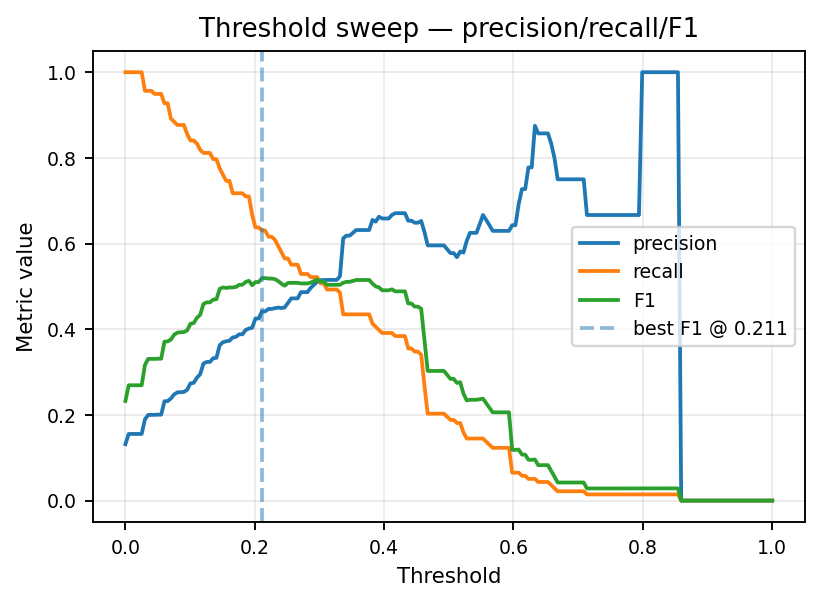

,top_frac,precision_at_k
0,0.01,0.800000
1,0.02,0.650000
2,0.05,0.615385
3,0.10,0.605769
4,0.20,0.425837


In [45]:
# ===== 11) THRESHOLD SWEEP & PR@k =====

if all(k in globals() for k in ["y_test", "p_test_final"]):
    y = np.asarray(y_test).astype(int)
    s = np.asarray(p_test_final).astype(float)

    # sweep 200 thresholds
    thr_grid = np.linspace(0, 1, 200)
    rows = []
    for t in thr_grid:
        yhat = (s >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
        rows.append((t, prec, rec, f1, yhat.mean()))
    sweep = pd.DataFrame(rows, columns=["thr","precision","recall","f1","flag_rate"])

    # pick best-F1 threshold (secondary tie-break: higher recall)
    best = sweep.sort_values(["f1","recall"], ascending=False).head(1).iloc[0].to_dict()
    display(pd.DataFrame([best]))

    # plot curves
    plt.figure()
    plt.plot(sweep["thr"], sweep["precision"], label="precision")
    plt.plot(sweep["thr"], sweep["recall"], label="recall")
    plt.plot(sweep["thr"], sweep["f1"], label="F1")
    plt.axvline(best["thr"], ls="--", alpha=0.5, label=f"best F1 @ {best['thr']:.3f}")
    plt.xlabel("Threshold"); plt.ylabel("Metric value"); plt.legend(); plt.grid(alpha=.25)
    plt.title("Threshold sweep — precision/recall/F1")
    save_fig_show("thr_sweep_prf1")

    # PR@k (top-k by score)
    ks = [0.01, 0.02, 0.05, 0.10, 0.20]
    out = []
    order = np.argsort(-s)  # desc
    for k in ks:
        m = max(1, int(len(s)*k))
        take = order[:m]
        pr_at_k = y[take].mean()
        out.append({"top_frac": k, "precision_at_k": float(pr_at_k)})
    display(pd.DataFrame(out))
else:
    print("Need y_test & p_test_final.")


,decile,precision@cum,lift,cum_capture
0,10,0.605769,4.600334,0.456522
1,20,0.425837,3.233895,0.644928
2,30,0.343949,2.612019,0.782609
3,40,0.276850,2.102452,0.840580
4,50,0.234733,1.782609,0.891304
5,60,0.207006,1.572048,0.942029
6,70,0.181446,1.377939,0.963768
7,80,0.163484,1.241534,0.992754
8,90,0.146341,1.111347,1.000000
9,100,0.131679,1.000000,1.000000


Saved: reports/figs/cumulative_gains_20250922_041445.png


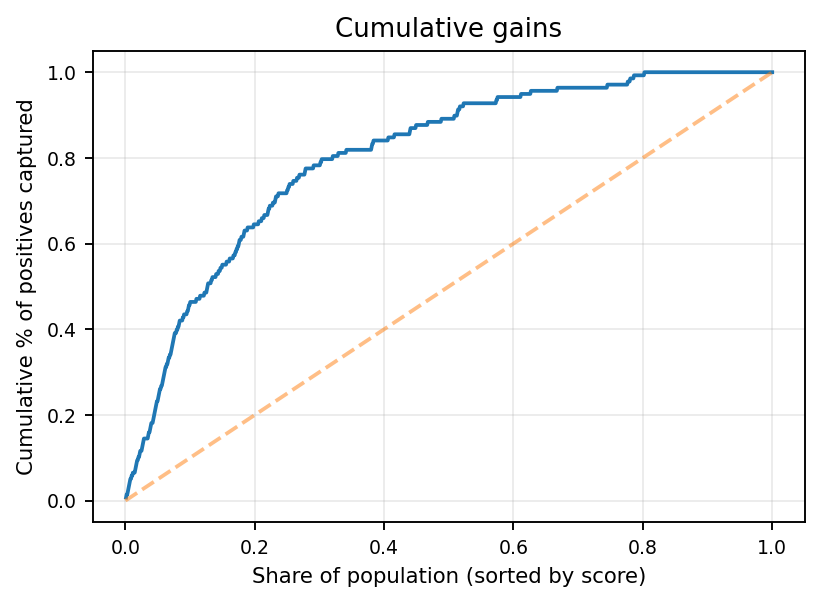

Saved: reports/figs/lift_by_decile_20250922_041445.png


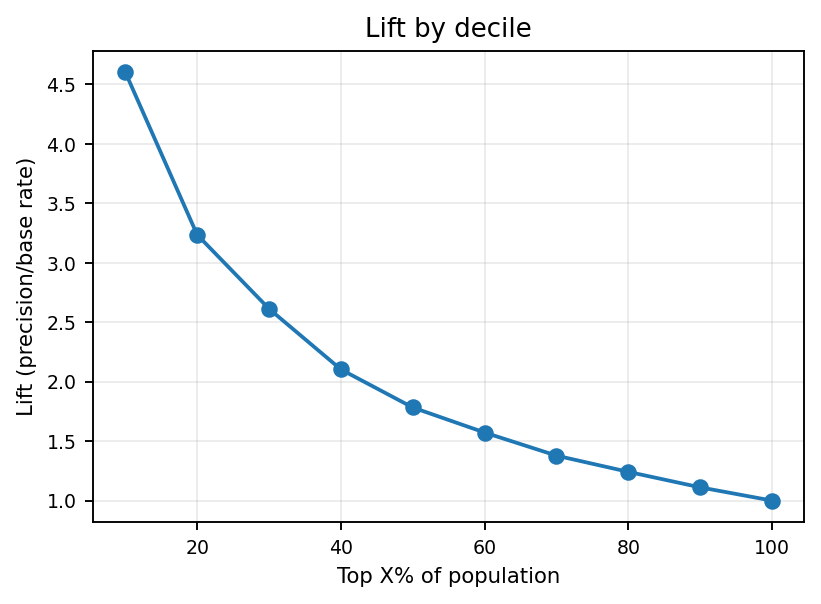

In [46]:
# ===== 12) lift & cumulative gains + decile table =====

if all(k in globals() for k in ["y_test", "p_test_final"]):
    y = np.asarray(y_test).astype(int)
    s = np.asarray(p_test_final).astype(float)
    base = y.mean()

    # order by score desc
    order = np.argsort(-s)
    y_ord = y[order]

    # cumulative capture
    cum_pos = np.cumsum(y_ord)
    pct = np.arange(1, len(y)+1)/len(y)
    capture = cum_pos / cum_pos[-1] if cum_pos[-1] > 0 else np.zeros_like(cum_pos)


    # lift per decile
    n = len(y)
    dec = []
    for d in range(1, 11):
        end = int(n*d/10)
        chunk = y_ord[:end]
        dec_prec = chunk.mean()
        lift = dec_prec / base if base > 0 else np.nan
        capture_at_d = cum_pos[end-1]/cum_pos[-1] if cum_pos[-1] > 0 else 0.0 # Handle division by zero
        dec.append({"decile": d*10, "precision@cum": float(dec_prec), "lift": float(lift), "cum_capture": float(capture_at_d)}) # Corrected syntax
    decile_df = pd.DataFrame(dec, columns=["decile","precision@cum","lift","cum_capture"])
    display(decile_df)

    # plots
    plt.figure()
    plt.plot(pct, capture)
    plt.plot([0,1],[0,1],'--',alpha=.5)
    plt.xlabel("Share of population (sorted by score)"); plt.ylabel("Cumulative % of positives captured")
    plt.title("Cumulative gains")
    plt.grid(alpha=.25)
    save_fig_show("cumulative_gains")

    plt.figure()
    plt.plot(decile_df["decile"], decile_df["lift"], marker="o")
    plt.xlabel("Top X% of population"); plt.ylabel("Lift (precision/base rate)")
    plt.title("Lift by decile")
    plt.grid(alpha=.25)
    save_fig_show("lift_by_decile")
else:
    print("Need y_test & p_test_final.")

In [47]:
# ===== 13) CALIBRATION BY BINS (TABLE) ======

def ece_binwise(y, p, n_bins=10):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    bins = np.linspace(0,1,n_bins+1)
    idx = np.clip(np.digitize(p, bins)-1, 0, n_bins-1)
    rows = []
    ece = 0.0
    for b in range(n_bins):
        mask = (idx==b)
        n = mask.sum()
        if n == 0:
            rows.append((b, bins[b], bins[b+1], 0, np.nan, np.nan, np.nan))
            continue
        obs = y[mask].mean()
        pred = p[mask].mean()
        rows.append((b, bins[b], bins[b+1], int(n), float(pred), float(obs), float(abs(obs-pred))))
        ece += (n/len(y))*abs(obs-pred)
    return pd.DataFrame(rows, columns=["bin","lo","hi","n","avg_pred","obs_rate","abs_gap"]), float(ece)

if all(k in globals() for k in ["y_test", "p_test_final"]):
    cal, ece = ece_binwise(y_test, p_test_final, n_bins=10)
    cal["brier_bin"] = (cal["obs_rate"] - cal["avg_pred"])**2
    display(cal)
    print(f"Overall ECE (10 bins): {ece:.3f} | Brier (global): {brier_score_loss(y_test, p_test_final):.3f}")
else:
    print("Need y_test & p_test_final.")


,bin,lo,hi,n,avg_pred,obs_rate,abs_gap,brier_bin
0,0,0.0,0.1,624,0.036862,0.035256,0.001606,0.000003
1,1,0.1,0.2,216,0.146105,0.125000,0.021105,0.000445
2,2,0.2,0.3,72,0.248975,0.263889,0.014914,0.000222
3,3,0.3,0.4,54,0.343845,0.296296,0.047548,0.002261
4,4,0.4,0.5,37,0.457036,0.756757,0.299721,0.089833
5,5,0.5,0.6,31,0.557591,0.548387,0.009204,0.000085
6,6,0.6,0.7,10,0.631921,0.600000,0.031921,0.001019
7,7,0.7,0.8,2,0.751845,0.500000,0.251845,0.063426
8,8,0.8,0.9,2,0.857143,1.000000,0.142857,0.020408
9,9,0.9,1.0,0,NaN,NaN,NaN,NaN


Overall ECE (10 bins): 0.021 | Brier (global): 0.086


In [53]:
# ===== 14) ERROR ANALYSIS: EXTREME ERRORS =====
if all(k in globals() for k in ["X_test","y_test","p_test_final"]):
    df_e = X_test.copy()
    df_e["y"] = np.asarray(y_test).astype(int)
    df_e["p"] = np.asarray(p_test_final).astype(float)

    for c in ["title","categoryId","channel_viewCount_log1p","channel_subscriberCount_log1p"]:
        if c not in df_e.columns:
            df_e[c] = np.nan

    tops = (df_e.sort_values("p", ascending=False))
    bot  = (df_e.sort_values("p", ascending=True))

    fp = tops[tops["y"]==0].head(15)[["title","categoryId","p","y"]]
    fn = bot [bot ["y"]==1].head(15)[["title","categoryId","p","y"]]

    print("Top false positives (high score but y=0):")
    display(fp)
    print("Top false negatives (low score but y=1):")
    display(fn)
else:
    print("Need X_test, y_test, p_test_final.")


Top false positives (high score but y=0):


,title,categoryId,p,y
1397,I Found Gold In Places Nobody Would Ever Look!,1,0.794118,0
3904,실장님과 계약을 종료했습니다.,19,0.630405,0
3654,CAMILA LOURES EVOLUIU MUITO ? AVALIAMOS O SHAP...,17,0.620242,0
5059,LA VUELTA DE MOSKI Y UN NUEVO INICIO,27,0.608267,0
2100,Paso Minecraft en un CARTEL!!,20,0.607324,0
1535,Trump’s OWN Judge SLAPS HIM DOWN and Gets TOSS...,25,0.594118,0
305,COMMANDING THE DAY MIDNIGHT PRAYER || TESTIMON...,29,0.594118,0
3419,I lost EVERYTHING in 99 Nights in the forest...,22,0.594118,0
3746,Encontré las PELIGROSAS PIRAÑAS del AMAZONAS,22,0.594118,0
2258,The Hindu Analysis Today | 2 September 2025 | ...,27,0.594118,0


Top false negatives (low score but y=1):


,title,categoryId,p,y
1368,ATLÉTICO-MG 0 x 2 CRUZEIRO | MELHORES MOMENTOS...,17,0.028125,1
234,"Olha os golpes da moda: OLX, Shopee, iFood e a...",24,0.028125,1
4711,Kanpur: 'I Love Mohammad' Board लगाने पर केस द...,25,0.028125,1
1597,D DOUBLE U THE NUMBER TWO,10,0.028125,1
4935,KPOP DEMON HUNTERS play SPIN THE BOTTLE in Rob...,20,0.028125,1
2772,Weapons company founded by 21-year-old lands a...,25,0.028571,1
2759,더뉴쏘렌토 넘버원 에디션 S급컨디션의 한정판 매물!! 1인신조까지 완벽합니다.// ...,2,0.040816,1
2329,Mocny start prezydentury! Nawrocki u Trumpa w ...,25,0.056696,1
3418,Eu fiz 100% de JETPACK JOYRIDE... e custou min...,20,0.056696,1
1790,AGORA OS ANTIS VÃO A LOUCURA COM FLAMENGO! MEN...,17,0.056696,1


Saved: reports/figs/ks_plot_20250922_041445.png


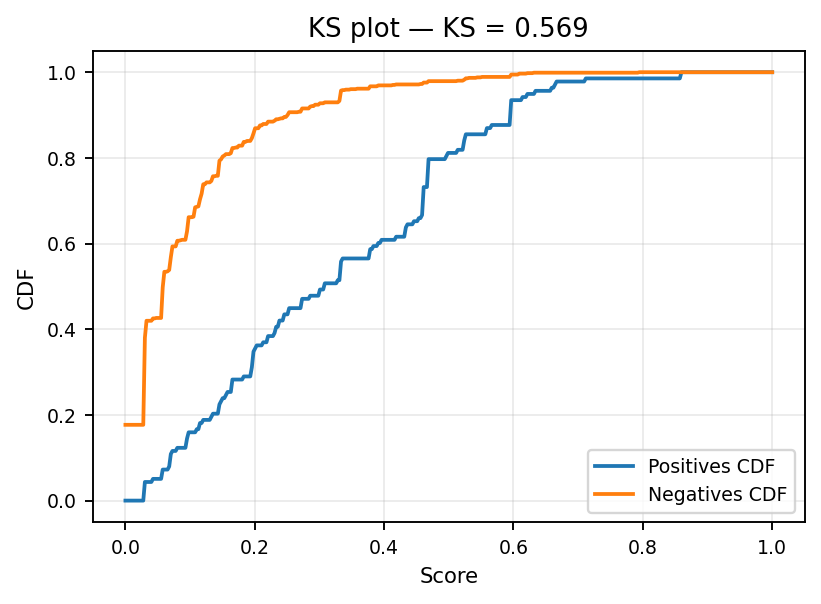

In [ ]:
# ===== 15) KS STATISTIC (max separation between CDFs) =====

if all(k in globals() for k in ["y_test","p_test_final"]):
    y = np.asarray(y_test).astype(int)
    s0 = np.sort(np.asarray(p_test_final)[y==0])
    s1 = np.sort(np.asarray(p_test_final)[y==1])

    # empirical CDFs on a common grid
    grid = np.linspace(0,1,400)
    def ecdf(x):
        return np.searchsorted(x, grid, side="right") / max(1,len(x))
    F0, F1 = ecdf(s0), ecdf(s1)
    ks = float(np.max(np.abs(F1 - F0)))

    plt.figure()
    plt.plot(grid, F1, label="Positives CDF")
    plt.plot(grid, F0, label="Negatives CDF")
    plt.title(f"KS plot — KS = {ks:.3f}")
    plt.xlabel("Score"); plt.ylabel("CDF"); plt.legend(); plt.grid(alpha=.25)
    save_fig_show("ks_plot")
else:
    print("Need y_test & p_test_final.")


Saved: reports/figs/decision_curve_20250922_041445.png


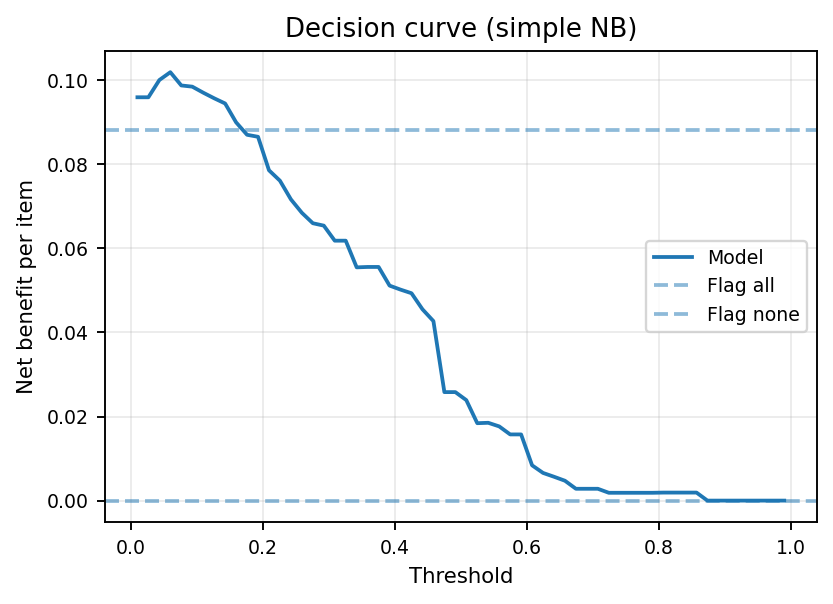

In [ ]:
# ===== 16) DECISION CURVE ANALYSIS (SIMPLE NET BENEFIT) =====

# define benefit/cost per action 
BENEFIT_TP = 1.0   # value of correctly flagging a viral item
COST_FP    = 0.05  # cost of incorrectly flagging a non-viral

if all(k in globals() for k in ["y_test","p_test_final"]):
    y = np.asarray(y_test).astype(int)
    s = np.asarray(p_test_final).astype(float)
    N = len(y)

    ts = np.linspace(0.01, 0.99, 60)
    nb = []
    for t in ts:
        yhat = (s >= t).astype(int)
        tp = ((yhat==1)&(y==1)).sum()
        fp = ((yhat==1)&(y==0)).sum()
        net_benefit = (BENEFIT_TP*tp - COST_FP*fp) / N
        nb.append(net_benefit)

    plt.figure()
    plt.plot(ts, nb, label="Model")
    # Two baselines
    treat_all = (BENEFIT_TP*y.sum() - COST_FP*(N - y.sum()))/N
    treat_none= 0.0
    plt.axhline(treat_all, ls="--", alpha=.5, label="Flag all")
    plt.axhline(treat_none, ls="--", alpha=.5, label="Flag none")
    plt.xlabel("Threshold"); plt.ylabel("Net benefit per item"); plt.legend(); plt.grid(alpha=.25)
    plt.title("Decision curve (simple NB)")
    save_fig_show("decision_curve")
else:
    print("Need y_test & p_test_final.")
